# Ternary plots of several scalar values

This notebook downloads all data and produces ternary plots. This notebook supports the publication:

An Inter-Laboratory Comparative High Throughput Experimental Study of Zn-Sn-Ti-O Thin Films

J. R. Hattrick-Simpers<sup>1</sup>, A. Zakutayev<sup>2</sup>, S. C. Barron<sup>1</sup>, Z. T. Trautt<sup>1</sup>, N. Nguyen<sup>1</sup>, K. Choudhary<sup>1</sup>, B. DeCost<sup>1</sup>, C. Phillips<sup>2</sup>, A. G. Kusne<sup>1</sup>, F. Yi<sup>1</sup>, A. Mehta<sup>3</sup>, I. Takeuchi<sup>4</sup>, J. D.Perkins<sup>2</sup>, M. L. Green<sup>1</sup>

1. National Institute of Standards and Technology (NIST), Gaithersburg, MD

1. National Renewable Energy Laboratory (NREL), Golden, CO

1. SLAC National Accelerator Laboratory, Menlo Park, CA

1. University of Maryland, College Park, MD

Contact: [htems@nist.gov](mailto:htems@nist.gov)

# Imports and Functions

In [1]:
import requests
requests.packages.urllib3.disable_warnings()
import json
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from ternarpy import * # Downloaded on June 6, 2018 from https://libraries.io/github/PhaethonPrime/ternarpy
import pandas as pd
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def check_response(r,quiet=False):
    try:
        r_content = r.json(object_pairs_hook=OrderedDict)
    except:
        r_content = r.text
    if str(r.status_code)[0] is not "2":
        if not quiet: print("Error: ",r.status_code) 
        if not quiet: print(r.text)
    else:
        return r_content

In [3]:
def mdcs_query(host,query,format='json'):
    url = host.strip("/") + "/rest/explore/query-by-example"
    data = dict()
    data['query'] = query
    data['dataformat'] = format
    r = requests.post(url, data=data, verify=False) # This needs to be fixed
    return check_response(r)

# Get the data

This may break in the future if future round robin datasets are added, which would require more specific queries.

In [4]:
host = "https://hte.registry.nist.gov/"

In [5]:
libraries = dict()
flip = {'a':'b','b':'a'}
library_pairs = dict()

query = '{"content.project.identifier.id":"20.500.12048/proj.2015.1"}'
query_response = mdcs_query(host,query)
project = query_response[0]['content']['project']
library_registry = project['library']

id_list = dict()
id_list['s_nist_c_nist'] = list()
id_list['s_nist_c_nrel'] = list()
id_list['s_nrel_c_nist'] = list()
id_list['s_nrel_c_nrel'] = list()


for lib in library_registry:
    lib_id = lib['identifier']['id']
    query = '{"content.library.identifier.id":"'+lib_id+'"}'
    query_response = mdcs_query(host,query)
    library = query_response[0]['content']['library']
    lib_name = library['name']
    org = library['associated']['organization']['altName']
    comment = library['comment']
    libraries[lib_id] = library
    if 'NIST' in comment:
        nist_id = lib_id
        end_char = nist_id[-1]
        nrel_id = nist_id[0:-1]+flip[end_char]
        library_pairs[nist_id] = nrel_id
        library_pairs[nrel_id] = nist_id
    
    if 'NIST' in org and 'NIST' in comment:
        id_list['s_nist_c_nist'].append(lib_id)
    if 'NIST' in org and 'NREL' in comment:
        id_list['s_nist_c_nrel'].append(lib_id)
    if 'NREL' in org and 'NIST' in comment:
        id_list['s_nrel_c_nist'].append(lib_id)
    if 'NREL' in org and 'NREL' in comment:
        id_list['s_nrel_c_nrel'].append(lib_id)

print(id_list['s_nist_c_nist'])
print(id_list['s_nist_c_nrel'])
print(id_list['s_nrel_c_nist'])
print(id_list['s_nrel_c_nrel'])

print(library_pairs)

['20.500.12048/lib.2015.1a']
['20.500.12048/lib.2015.1b']
['20.500.12048/lib.2016.1b', '20.500.12048/lib.2016.2b', '20.500.12048/lib.2016.3b']
['20.500.12048/lib.2016.1a', '20.500.12048/lib.2016.2a', '20.500.12048/lib.2016.3a']
{'20.500.12048/lib.2015.1a': '20.500.12048/lib.2015.1b', '20.500.12048/lib.2015.1b': '20.500.12048/lib.2015.1a', '20.500.12048/lib.2016.1b': '20.500.12048/lib.2016.1a', '20.500.12048/lib.2016.1a': '20.500.12048/lib.2016.1b', '20.500.12048/lib.2016.2b': '20.500.12048/lib.2016.2a', '20.500.12048/lib.2016.2a': '20.500.12048/lib.2016.2b', '20.500.12048/lib.2016.3b': '20.500.12048/lib.2016.3a', '20.500.12048/lib.2016.3a': '20.500.12048/lib.2016.3b'}


# Parse Data

In [6]:
data_list = dict()
data_list['s_nist_c_nist'] = list()
data_list['s_nist_c_nrel'] = list()
data_list['s_nrel_c_nist'] = list()
data_list['s_nrel_c_nrel'] = list()
columns = list()
set_column_element = True
set_column_property = True
for group,members in id_list.items():
    print(group)
    for lib_id in members:
        print("\t"+lib_id)
        for sample_num,sample in enumerate(libraries[lib_id]['sample']):
            item = list()
            try:
                for c in sample['composition']['constituent']:
                    if set_column_element:
                        columns.append(c['chemical-formula'])
                    try:
                        item.append(c['quantity'])
                    except:
                        item.append(0.0)
            except:
                sibling_sample = libraries[library_pairs[lib_id]]['sample'][sample_num]
                for c in sibling_sample['composition']['constituent']:
                    try:
                        item.append(c['quantity'])
                    except:
                        item.append(0.0)
            for p in sample['property']:
                if set_column_property:
                    columns.append(p['name'])
                try:
                    item.append(p['value'])
                except:
                    item.append(0.0)
            set_column_element = False
            set_column_property = False
            data_list[group].append(item)

s_nist_c_nist
	20.500.12048/lib.2015.1a
s_nist_c_nrel
	20.500.12048/lib.2015.1b
s_nrel_c_nist
	20.500.12048/lib.2016.1b
	20.500.12048/lib.2016.2b
	20.500.12048/lib.2016.3b
s_nrel_c_nrel
	20.500.12048/lib.2016.1a
	20.500.12048/lib.2016.2a
	20.500.12048/lib.2016.3a


In [7]:
columns

['Zn',
 'Sn',
 'Ti',
 'O',
 'film thickness',
 'conductivity',
 'sheet resistance',
 'band gap']

In [8]:
my_order= [2,0,1,3,4,5,6,7]
my_columns = [columns[i] for i in my_order]

In [9]:
my_columns

['Ti',
 'Zn',
 'Sn',
 'O',
 'film thickness',
 'conductivity',
 'sheet resistance',
 'band gap']

# Plot Band Gap

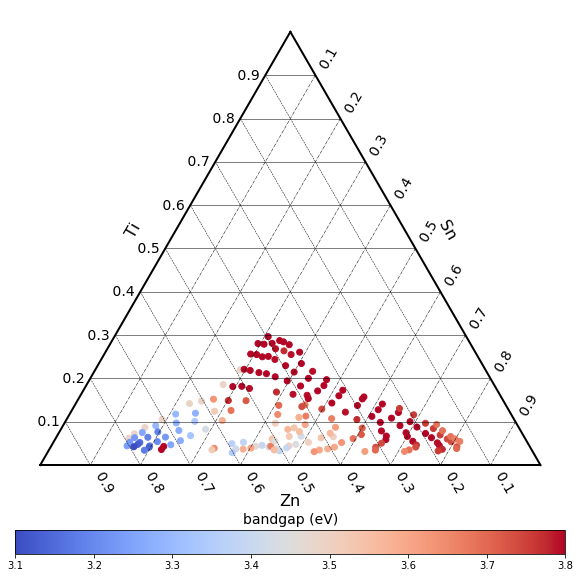

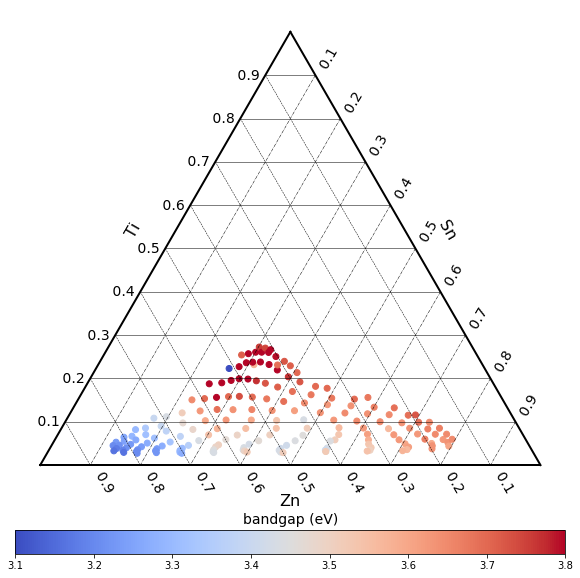

In [10]:
nist_df = pd.DataFrame(np.array(data_list['s_nist_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nist_c_nrel']),columns=columns)
basis = make_basis()
nist_X = nist_df[my_columns[0:3]].as_matrix()
nrel_X = nrel_df[my_columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=nist_df['band gap'], cmap='coolwarm', vmin=3.1, vmax=3.8);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('bandgap (eV)', size=14)
plt.savefig("band-gap-NIST-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=nrel_df['band gap'], cmap='coolwarm', vmin=3.1, vmax=3.8);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('bandgap (eV)', size=14)
plt.savefig("band-gap-NIST-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

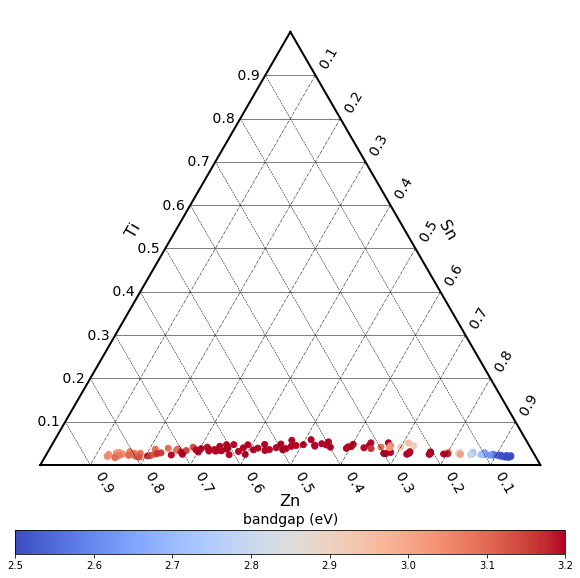

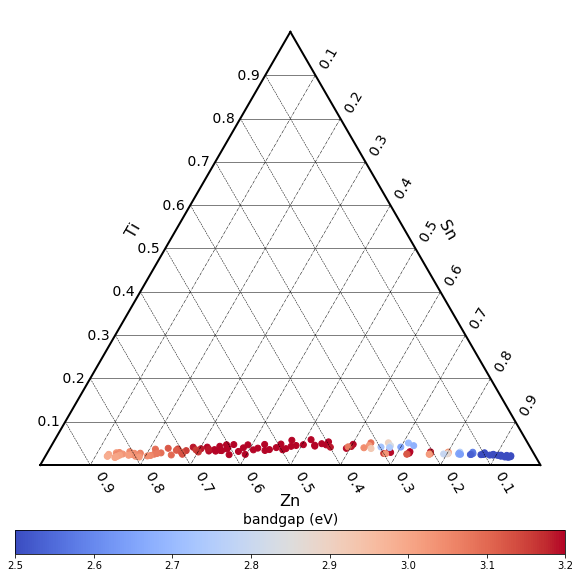

In [11]:
nist_df = pd.DataFrame(np.array(data_list['s_nrel_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nrel_c_nrel']),columns=columns)
basis = make_basis()
nist_X = nist_df[my_columns[0:3]].as_matrix()
nrel_X = nrel_df[my_columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=nist_df['band gap'], cmap='coolwarm', vmin=2.5, vmax=3.2);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('bandgap (eV)', size=14)
plt.savefig("band-gap-NREL-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=nrel_df['band gap'], cmap='coolwarm', vmin=2.5, vmax=3.2);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('bandgap (eV)', size=14)
plt.savefig("band-gap-NREL-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

# Plot Thickness

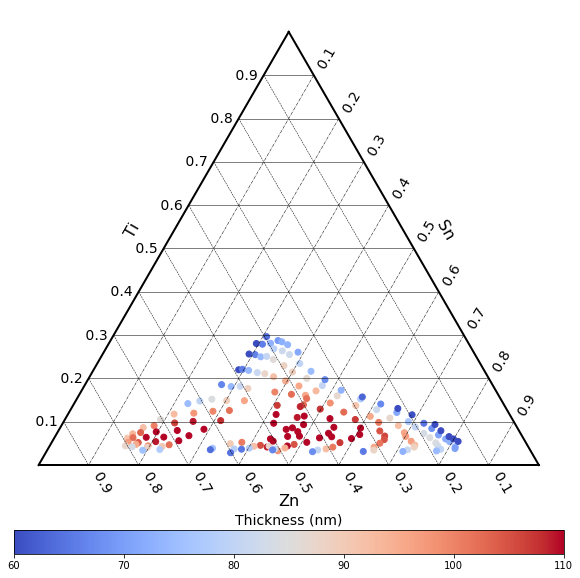

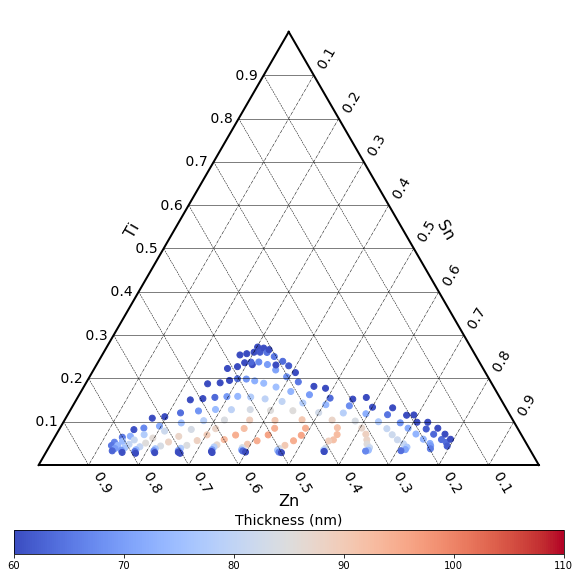

In [12]:
nist_df = pd.DataFrame(np.array(data_list['s_nist_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nist_c_nrel']),columns=columns)
basis = make_basis()
nist_X = nist_df[my_columns[0:3]].as_matrix()
nrel_X = nrel_df[my_columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=nist_df['film thickness'], cmap='coolwarm', vmin=60, vmax=110);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('Thickness (nm)', size=14)
plt.savefig("thickness-NIST-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=nrel_df['film thickness'], cmap='coolwarm', vmin=60, vmax=110);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('Thickness (nm)', size=14)
plt.savefig("thickness-NIST-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

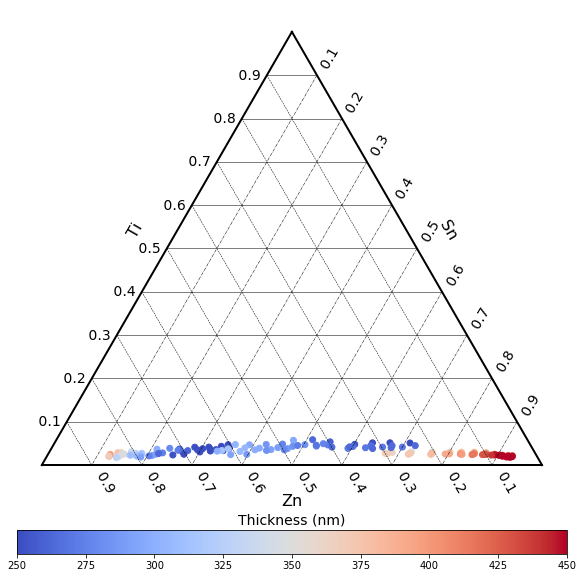

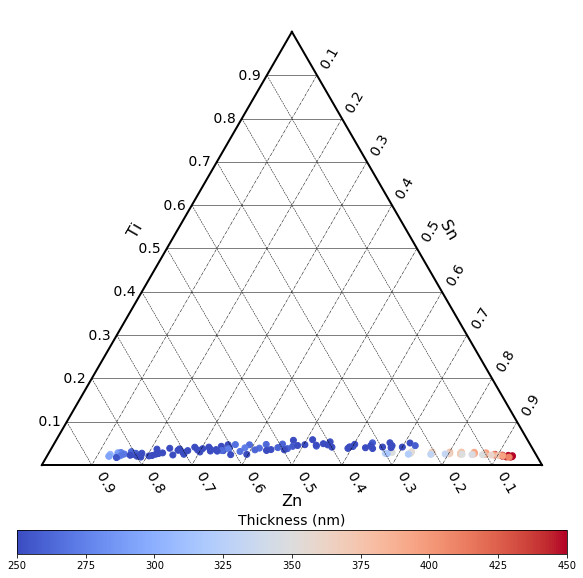

In [13]:
nist_df = pd.DataFrame(np.array(data_list['s_nrel_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nrel_c_nrel']),columns=columns)
basis = make_basis()
nist_X = nist_df[my_columns[0:3]].as_matrix()
nrel_X = nrel_df[my_columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=nist_df['film thickness'], cmap='coolwarm', vmin=250, vmax=450);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('Thickness (nm)', size=14)
plt.savefig("thickness-NREL-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=nrel_df['film thickness'], cmap='coolwarm', vmin=250, vmax=450);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('Thickness (nm)', size=14)
plt.savefig("thickness-NREL-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

# Plot Conductivity

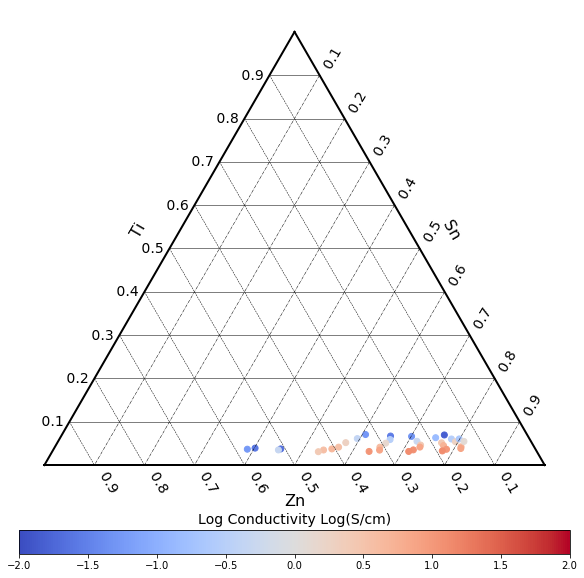

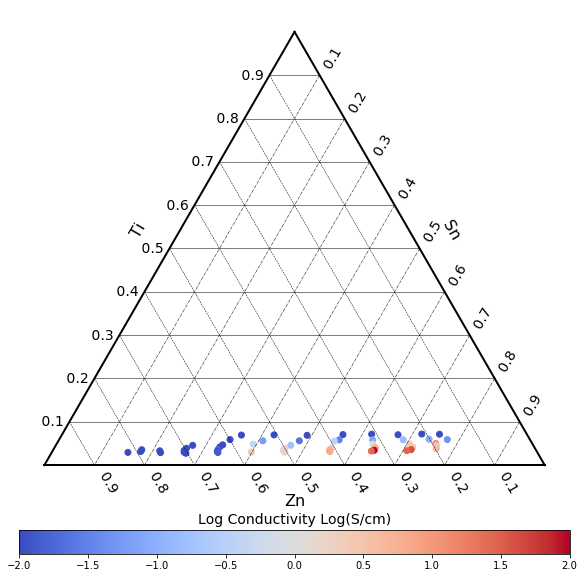

In [14]:
nist_df = pd.DataFrame(np.array(data_list['s_nist_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nist_c_nrel']),columns=columns)
nist_df_valid = nist_df[nist_df['conductivity'] > 0]
nrel_df_valid = nrel_df[nrel_df['conductivity'] > 0]
basis = make_basis()
nist_X = nist_df_valid[my_columns[0:3]].as_matrix()
nrel_X = nrel_df_valid[my_columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=np.log10(nist_df_valid['conductivity']), cmap='coolwarm', 
                    vmin=-2, vmax=2);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('Log Conductivity Log(S/cm)', size=14)
plt.savefig("conductivity-NIST-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=np.log10(nrel_df_valid['conductivity']), cmap='coolwarm', 
                    vmin=-2, vmax=2);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('Log Conductivity Log(S/cm)', size=14)
plt.savefig("conductivity-NIST-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

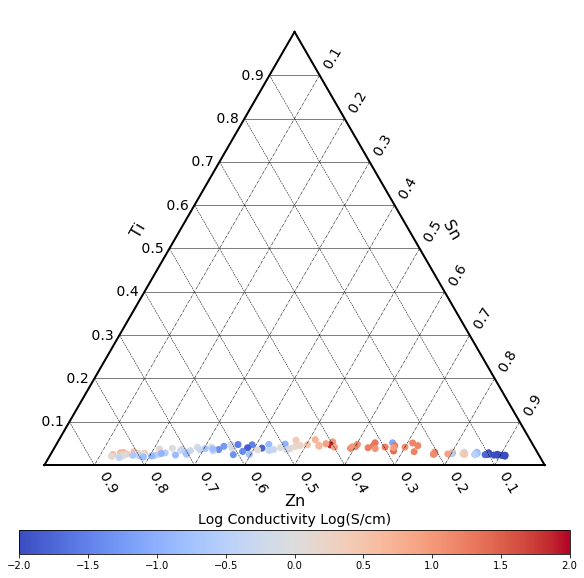

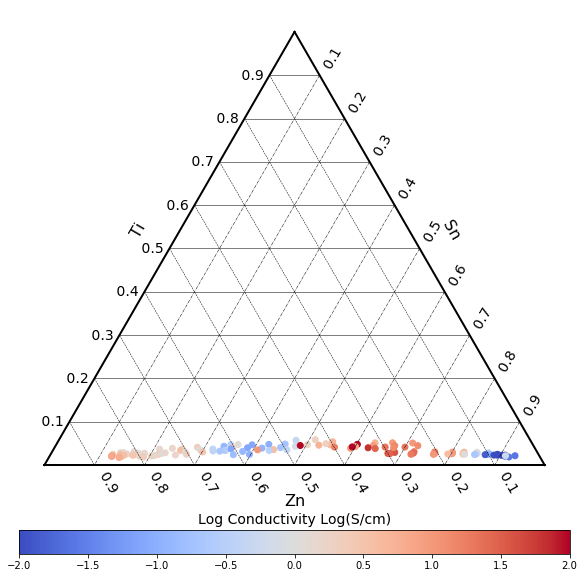

In [15]:
nist_df = pd.DataFrame(np.array(data_list['s_nrel_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nrel_c_nrel']),columns=columns)
nist_df_valid = nist_df[nist_df['conductivity'] > 0]
nrel_df_valid = nrel_df[nrel_df['conductivity'] > 0]
basis = make_basis()
nist_X = nist_df_valid[my_columns[0:3]].as_matrix()
nrel_X = nrel_df_valid[my_columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=np.log10(nist_df_valid['conductivity']), cmap='coolwarm', 
                    vmin=-2, vmax=2);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('Log Conductivity Log(S/cm)', size=14)
plt.savefig("conductivity-NREL-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=np.log10(nrel_df_valid['conductivity']), cmap='coolwarm', 
                    vmin=-2, vmax=2);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('Log Conductivity Log(S/cm)', size=14)
plt.savefig("conductivity-NREL-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

# Plot Sheet Resistance

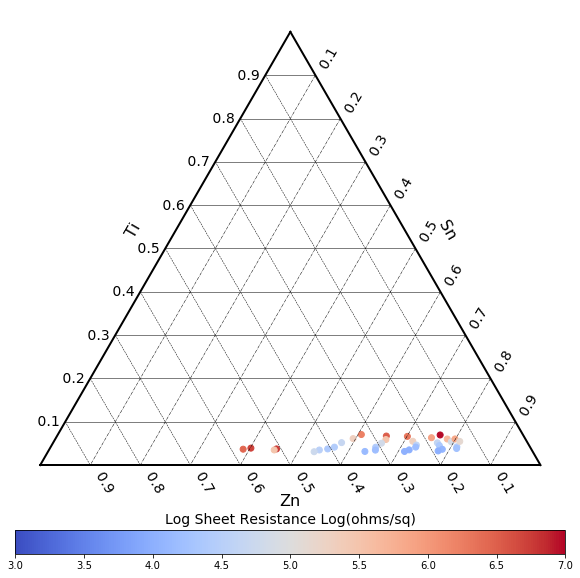

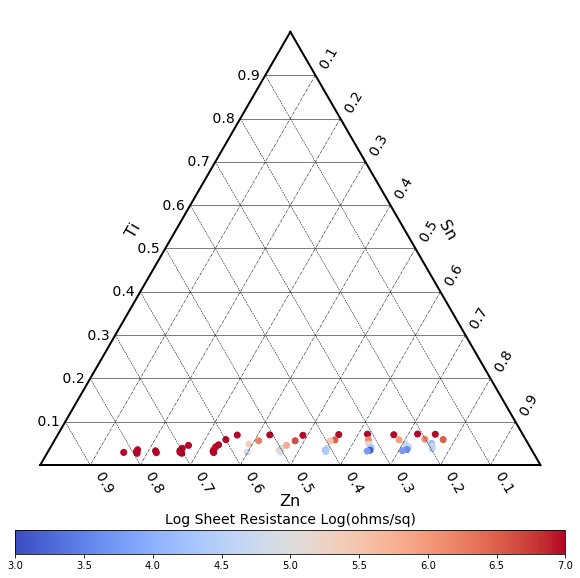

In [16]:
nist_df = pd.DataFrame(np.array(data_list['s_nist_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nist_c_nrel']),columns=columns)
nist_df_valid = nist_df[nist_df['sheet resistance'] > 0]
nrel_df_valid = nrel_df[nrel_df['sheet resistance'] > 0]
basis = make_basis()
nist_X = nist_df_valid[my_columns[0:3]].as_matrix()
nrel_X = nrel_df_valid[my_columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=np.log10(nist_df_valid['sheet resistance']), cmap='coolwarm', 
                    vmin=3, vmax=7);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('Log Sheet Resistance Log(ohms/sq)', size=14)
plt.savefig("sheet-resistance-NIST-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=np.log10(nrel_df_valid['sheet resistance']), cmap='coolwarm', 
                    vmin=3, vmax=7);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('Log Sheet Resistance Log(ohms/sq)', size=14)
plt.savefig("sheet-resistance-NIST-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

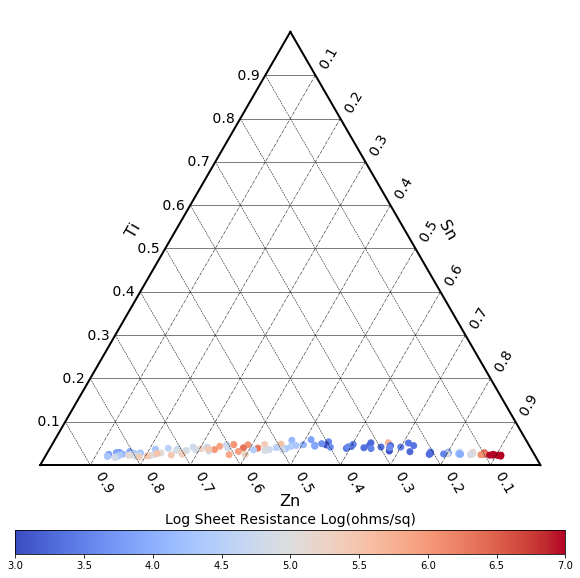

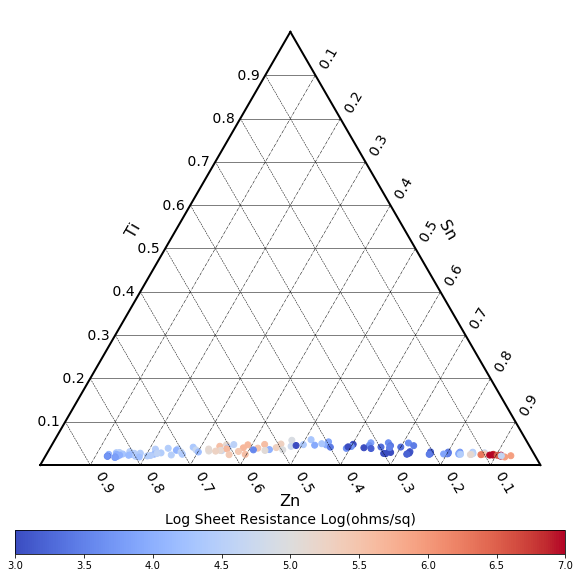

In [17]:
nist_df = pd.DataFrame(np.array(data_list['s_nrel_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nrel_c_nrel']),columns=columns)
nist_df_valid = nist_df[nist_df['sheet resistance'] > 0]
nrel_df_valid = nrel_df[nrel_df['sheet resistance'] > 0]
basis = make_basis()
nist_X = nist_df_valid[my_columns[0:3]].as_matrix()
nrel_X = nrel_df_valid[my_columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=np.log10(nist_df_valid['sheet resistance']), cmap='coolwarm', 
                    vmin=3, vmax=7);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('Log Sheet Resistance Log(ohms/sq)', size=14)
plt.savefig("sheet-resistance-NREL-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=my_columns[0:3], grid_values=np.arange(0.1,1,0.1),label_offset=0.25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=np.log10(nrel_df_valid['sheet resistance']), cmap='coolwarm', 
                    vmin=3, vmax=7);
plt.colorbar(points,cax=cax,orientation="horizontal").ax.set_title('Log Sheet Resistance Log(ohms/sq)', size=14)
plt.savefig("sheet-resistance-NREL-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

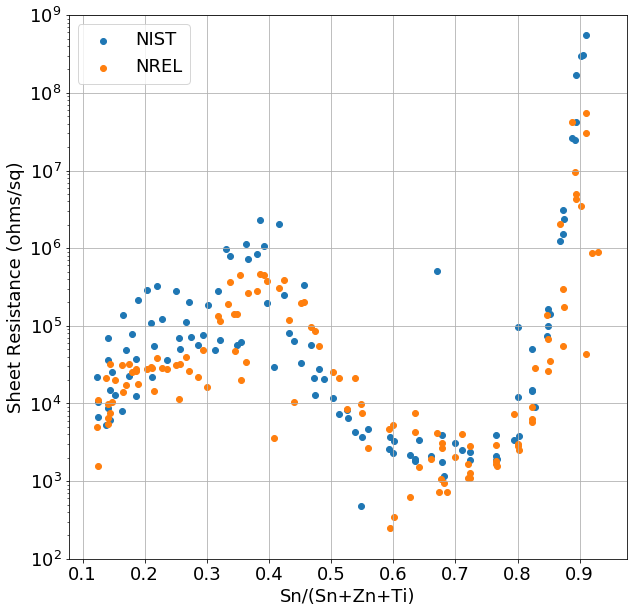

In [18]:
nist_df = pd.DataFrame(np.array(data_list['s_nrel_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nrel_c_nrel']),columns=columns)
nist_df_valid = nist_df[nist_df['sheet resistance'] > 0]
nrel_df_valid = nrel_df[nrel_df['sheet resistance'] > 0]

lower = 10**2
upper = 10**9
colors = 'krgb'
font = {'size'   : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_yscale('log')
plt.scatter(nist_df_valid['Sn'],nist_df_valid['sheet resistance'], label = "NIST")
plt.scatter(nrel_df_valid['Sn'],nrel_df_valid['sheet resistance'], label = "NREL")
plt.legend()
plt.xlabel('Sn/(Sn+Zn+Ti)')
plt.ylabel('Sheet Resistance (ohms/sq)')
plt.ylim(lower, upper)
plt.grid(True)
plt.savefig("sheet-resistance-NREL-samples-Sn.pdf", bbox_inches='tight')
plt.show()

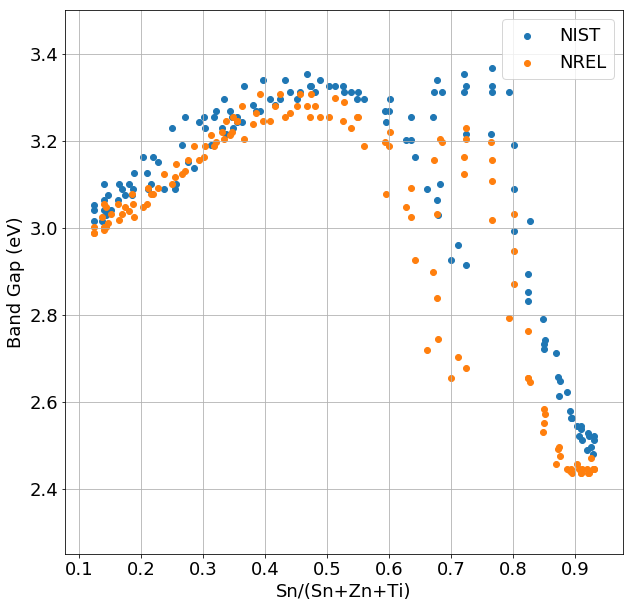

In [19]:
nist_df = pd.DataFrame(np.array(data_list['s_nrel_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nrel_c_nrel']),columns=columns)

lower = 2.25
upper = 3.5
colors = 'krgb'
font = {'size'   : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.scatter(nist_df['Sn'],nist_df['band gap'], label = "NIST")
plt.scatter(nrel_df['Sn'],nrel_df['band gap'], label = "NREL")
plt.legend()
plt.xlabel('Sn/(Sn+Zn+Ti)')
plt.ylabel('Band Gap (eV)')
plt.ylim(lower, upper)
plt.grid(True)
plt.savefig("band-gap-NREL-samples-Sn.pdf", bbox_inches='tight')
plt.show()

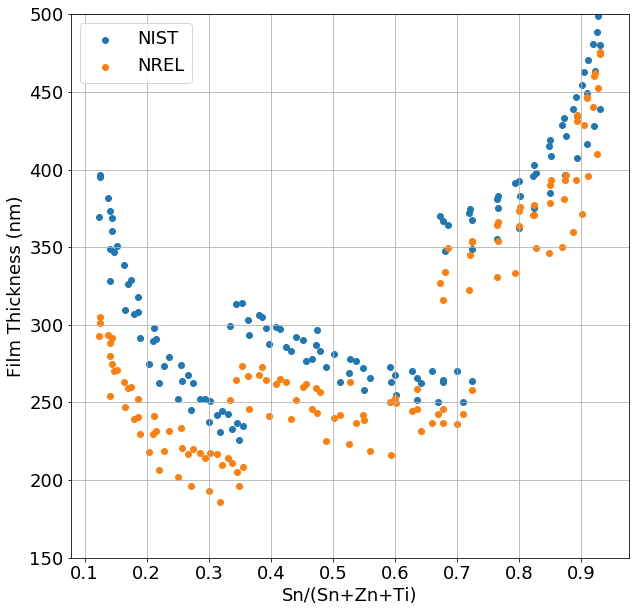

In [20]:
nist_df = pd.DataFrame(np.array(data_list['s_nrel_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nrel_c_nrel']),columns=columns)

lower = 150
upper = 500
colors = 'krgb'
font = {'size'   : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.scatter(nist_df['Sn'],nist_df['film thickness'], label = "NIST")
plt.scatter(nrel_df['Sn'],nrel_df['film thickness'], label = "NREL")
plt.legend()
plt.xlabel('Sn/(Sn+Zn+Ti)')
plt.ylabel('Film Thickness (nm)')
plt.ylim(lower, upper)
plt.grid(True)
plt.savefig("film-thickness-NREL-samples-Sn.pdf", bbox_inches='tight')
plt.show()

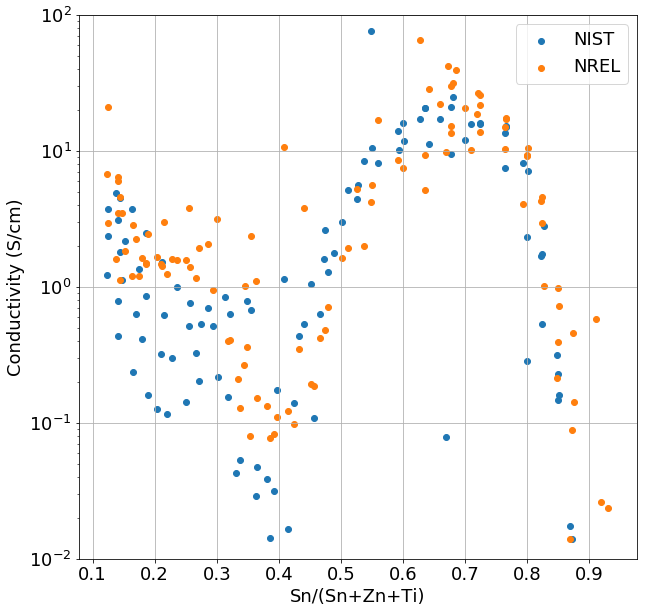

In [21]:
nist_df = pd.DataFrame(np.array(data_list['s_nrel_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nrel_c_nrel']),columns=columns)

lower = 10**-2
upper = 10**2
colors = 'krgb'
font = {'size'   : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_yscale('log')
plt.scatter(nist_df['Sn'],nist_df['conductivity'], label = "NIST")
plt.scatter(nrel_df['Sn'],nrel_df['conductivity'], label = "NREL")
plt.legend()
plt.xlabel('Sn/(Sn+Zn+Ti)')
plt.ylabel('Conductivity (S/cm)')
plt.ylim(lower, upper)
plt.grid(True)
plt.savefig("conductivity-NREL-samples-Sn.pdf", bbox_inches='tight')
plt.show()